In [1]:
import sys
assert sys.version_info >= (3, 5)

from collections import defaultdict
from datetime import datetime
import json
import logging
import os
from pathlib import Path
import random
import re
import sys
from typing import Dict, Tuple
import urllib
from zipfile import ZipFile

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load and preprocess data

In [2]:
!ls

20200101-20211217 ERCOT Day-Ahead Price.csv
20210101-20211213 ERCOT Day-Ahead Price.csv
20210101-20211217 ERCOT Real-time Price.csv
20210101-20211226 ERCOT Day-Ahead Price.csv
DAM_analysis.ipynb
Realtime_DAM_analysis.ipynb


In [3]:
# DAM(Day ahead Market) data
df_dam = pd.read_csv ('20210101-20211226 ERCOT Day-Ahead Price.csv')


In [4]:
df_dam.head

<bound method NDFrame.head of                          Date  price        zone
0        1/1/2021 12:00:00 AM  24.11      LZ_AEN
1        1/1/2021 12:00:00 AM  18.46      LZ_CPS
2        1/1/2021 12:00:00 AM  18.31  LZ_HOUSTON
3        1/1/2021 12:00:00 AM  18.95     LZ_LCRA
4        1/1/2021 12:00:00 AM  18.18    LZ_NORTH
...                       ...    ...         ...
68923  12/26/2021 12:00:00 AM  33.00     LZ_LCRA
68924  12/26/2021 12:00:00 AM  33.46    LZ_NORTH
68925  12/26/2021 12:00:00 AM  33.59    LZ_RAYBN
68926  12/26/2021 12:00:00 AM  32.50    LZ_SOUTH
68927  12/26/2021 12:00:00 AM  33.10     LZ_WEST

[68928 rows x 3 columns]>

In [5]:
df_dam.dtypes


Date      object
price    float64
zone      object
dtype: object

In [6]:
df_dam.zone.apply(str)


0            LZ_AEN
1            LZ_CPS
2        LZ_HOUSTON
3           LZ_LCRA
4          LZ_NORTH
            ...    
68923       LZ_LCRA
68924      LZ_NORTH
68925      LZ_RAYBN
68926      LZ_SOUTH
68927       LZ_WEST
Name: zone, Length: 68928, dtype: object

In [7]:
df_dam['Date']= pd.to_datetime(df_dam['Date'])

In [8]:
df_dam.dtypes

Date     datetime64[ns]
price           float64
zone             object
dtype: object

In [9]:
df_dam.head

<bound method NDFrame.head of             Date  price        zone
0     2021-01-01  24.11      LZ_AEN
1     2021-01-01  18.46      LZ_CPS
2     2021-01-01  18.31  LZ_HOUSTON
3     2021-01-01  18.95     LZ_LCRA
4     2021-01-01  18.18    LZ_NORTH
...          ...    ...         ...
68923 2021-12-26  33.00     LZ_LCRA
68924 2021-12-26  33.46    LZ_NORTH
68925 2021-12-26  33.59    LZ_RAYBN
68926 2021-12-26  32.50    LZ_SOUTH
68927 2021-12-26  33.10     LZ_WEST

[68928 rows x 3 columns]>

In [10]:
df_dam = df_dam [df_dam['zone']=='LZ_NORTH']

In [11]:
df_dam.head

<bound method NDFrame.head of                      Date  price      zone
4     2021-01-01 00:00:00  18.18  LZ_NORTH
12    2021-01-01 01:00:00  17.56  LZ_NORTH
20    2021-01-01 02:00:00  17.02  LZ_NORTH
28    2021-01-01 03:00:00  17.14  LZ_NORTH
36    2021-01-01 04:00:00  17.18  LZ_NORTH
...                   ...    ...       ...
68892 2021-12-25 20:00:00  27.81  LZ_NORTH
68900 2021-12-25 21:00:00  25.97  LZ_NORTH
68908 2021-12-25 22:00:00  27.49  LZ_NORTH
68916 2021-12-25 23:00:00  27.32  LZ_NORTH
68924 2021-12-26 00:00:00  33.46  LZ_NORTH

[8616 rows x 3 columns]>

# Analysis ( ignore Feb for now)

In [13]:
df_dam['month'] = df_dam['Date'].dt.month
df_dam['year'] = df_dam['Date'].dt.year
df_dam['day'] = df_dam['Date'].dt.date
df_dam = df_dam[df_dam['year'] == 2021]

<ipython-input-13-80dbd679211e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dam['month'] = df_dam['Date'].dt.month
<ipython-input-13-80dbd679211e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dam['year'] = df_dam['Date'].dt.year
<ipython-input-13-80dbd679211e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [14]:
df_dam.head

<bound method NDFrame.head of                      Date  price      zone  month  year         day
4     2021-01-01 00:00:00  18.18  LZ_NORTH      1  2021  2021-01-01
12    2021-01-01 01:00:00  17.56  LZ_NORTH      1  2021  2021-01-01
20    2021-01-01 02:00:00  17.02  LZ_NORTH      1  2021  2021-01-01
28    2021-01-01 03:00:00  17.14  LZ_NORTH      1  2021  2021-01-01
36    2021-01-01 04:00:00  17.18  LZ_NORTH      1  2021  2021-01-01
...                   ...    ...       ...    ...   ...         ...
68892 2021-12-25 20:00:00  27.81  LZ_NORTH     12  2021  2021-12-25
68900 2021-12-25 21:00:00  25.97  LZ_NORTH     12  2021  2021-12-25
68908 2021-12-25 22:00:00  27.49  LZ_NORTH     12  2021  2021-12-25
68916 2021-12-25 23:00:00  27.32  LZ_NORTH     12  2021  2021-12-25
68924 2021-12-26 00:00:00  33.46  LZ_NORTH     12  2021  2021-12-26

[8616 rows x 6 columns]>

In [16]:
#ignore Feb
df_dam = df_dam [df_dam['month'] != 2]


In [17]:
df_dam.describe()

,price,month,year
count,7944.000000,7944.000000,7944.0
mean,36.110837,6.810801,2021.0
std,40.997955,3.279514,0.0
min,0.140000,1.000000,2021.0
25%,21.440000,4.000000,2021.0
50%,29.120000,7.000000,2021.0
75%,40.722500,10.000000,2021.0
max,1497.800000,12.000000,2021.0


In [18]:
df_dam.groupby('month').mean()

,price,year
month,,
1,21.757325,2021
3,21.130767,2021
4,30.515000,2021
5,25.030094,2021
6,42.798667,2021
7,41.966532,2021
8,42.333952,2021
9,45.837375,2021
10,54.628831,2021


<AxesSubplot:xlabel='month'>

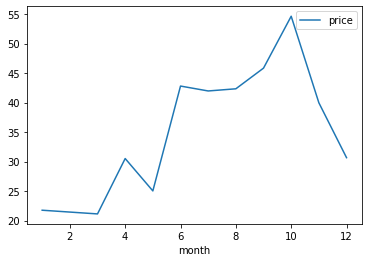

In [19]:
df_dam.drop('year', axis=1, inplace=True)

df_dam.groupby('month').mean().plot(legend=True)

In [20]:
df_price_ng = df_dam.groupby('month').mean().reset_index()

In [21]:
df_price_ng.head

<bound method NDFrame.head of     month      price
0       1  21.757325
1       3  21.130767
2       4  30.515000
3       5  25.030094
4       6  42.798667
5       7  41.966532
6       8  42.333952
7       9  45.837375
8      10  54.628831
9      11  39.964681
10     12  30.661830>

In [22]:
#https://www.eia.gov/dnav/ng/hist/rngwhhdm.htm
df_price_ng['natural_gas_price'] = [2.71, 2.62,2.66, 2.91, 3.26, 3.84, 4.07, 5.16, 5.51, 5.05, 3.6]

In [23]:
df_price_ng.columns

Index(['month', 'price', 'natural_gas_price'], dtype='object')

<AxesSubplot:title={'center':'2021 Monthly NG price'}, xlabel='month'>

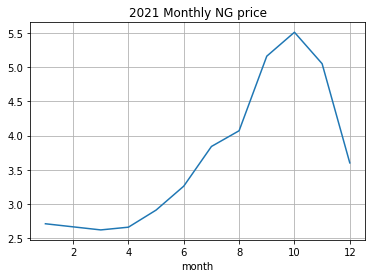

In [24]:
df_price_ng.plot(x ='month', y='natural_gas_price', kind = 'line', title="2021 Monthly NG price", 
                      grid=True, legend=False)

# Curtail for DAM

In [26]:
curtail_analysis = pd.DataFrame(columns = ['curtail', 'average', 'uptime'])

curtail_analysis.drop(curtail_analysis.index, inplace=True)

In [27]:
curtail_analysis.head

<bound method NDFrame.head of Empty DataFrame
Columns: [curtail, average, uptime]
Index: []>

In [30]:
df_dam_day= df_dam.groupby(['day'])['price'].mean().to_frame()

In [34]:
df_dam = pd.merge(df_dam, df_dam_day, on=['day'], how='inner',suffixes=('','_day_avg'))


In [35]:
df_dam.head

<bound method NDFrame.head of                     Date  price      zone  month         day  price_day_avg
0    2021-01-01 00:00:00  18.18  LZ_NORTH      1  2021-01-01      20.511667
1    2021-01-01 01:00:00  17.56  LZ_NORTH      1  2021-01-01      20.511667
2    2021-01-01 02:00:00  17.02  LZ_NORTH      1  2021-01-01      20.511667
3    2021-01-01 03:00:00  17.14  LZ_NORTH      1  2021-01-01      20.511667
4    2021-01-01 04:00:00  17.18  LZ_NORTH      1  2021-01-01      20.511667
...                  ...    ...       ...    ...         ...            ...
7939 2021-12-25 20:00:00  27.81  LZ_NORTH     12  2021-12-25      24.495417
7940 2021-12-25 21:00:00  25.97  LZ_NORTH     12  2021-12-25      24.495417
7941 2021-12-25 22:00:00  27.49  LZ_NORTH     12  2021-12-25      24.495417
7942 2021-12-25 23:00:00  27.32  LZ_NORTH     12  2021-12-25      24.495417
7943 2021-12-26 00:00:00  33.46  LZ_NORTH     12  2021-12-26      33.460000

[7944 rows x 6 columns]>

****************************************************************************************************
Curtail at 50
           price  price_day_avg
month                          
1      21.251049      21.644169
3      20.114455      21.009231
4      23.295657      29.204963
5      24.158306      24.914479
6      27.224281      39.278144
7      30.201244      39.961654
8      31.929072      41.399554
9      34.297750      45.294953
10     38.795104      51.399800
11     33.371073      38.112012
12     27.797971      30.441656
Overall Average  27.675564946619282
Uptime percentage  0.8489425981873112
****************************************************************************************************
Curtail at 55
           price  price_day_avg
month                          
1      21.424431      21.688678
3      20.376881      21.041203
4      23.698079      29.263925
5      24.536277      24.976521
6      27.775039      39.289782
7      31.330233      39.995435
8      33.213984      41

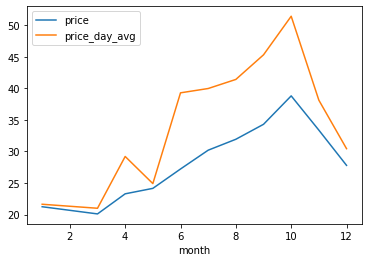

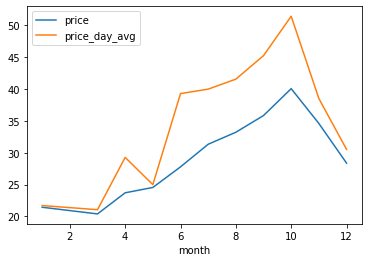

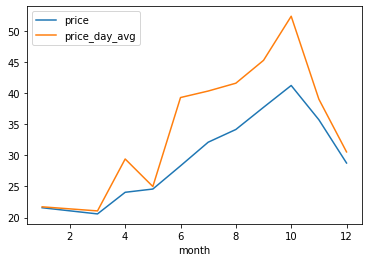

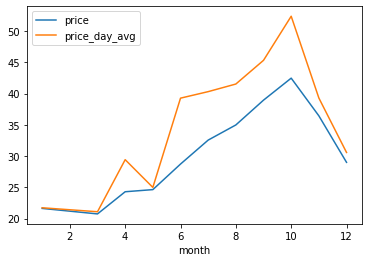

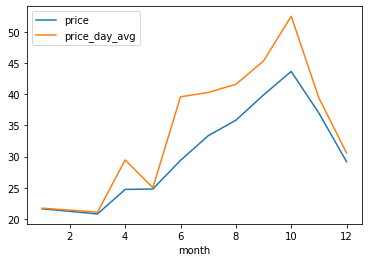

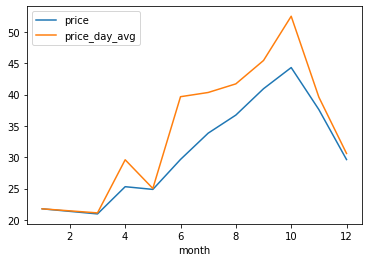

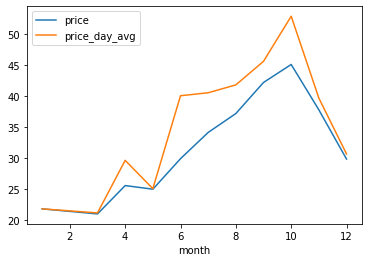

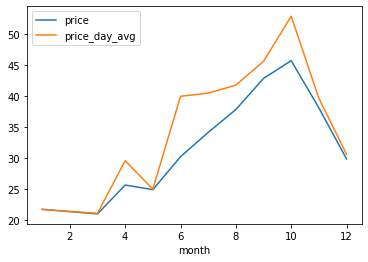

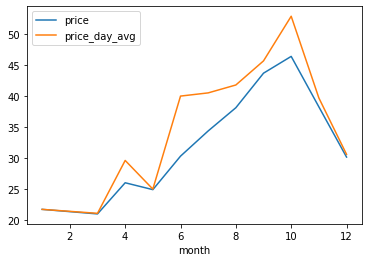

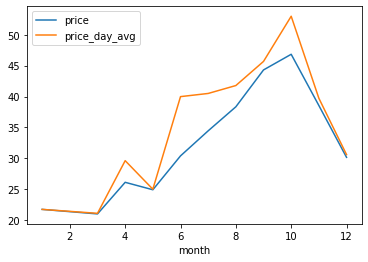

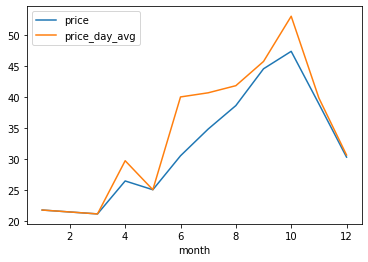

In [42]:
avg_threshold = 30 
def curtail_function(row, curtail):
    if row['price'] <= curtail:
        return 'N'
    return 'Y'
for curtail in range(50,105, 5):
    print("*"*100)
    print("Curtail at "+ str(curtail))
    df_dam['curtail'] = df_dam.apply( lambda row: curtail_function(row, curtail), axis = 1)
    df_curtail = df_dam [df_dam['curtail'] == 'N' ]
    print(df_curtail.groupby('month').mean())
    df_curtail.groupby('month').mean().plot(legend=True)
    print("Overall Average ", df_curtail['price'].mean())
    print("Uptime percentage ", df_curtail['Date'].count()/df_dam['Date'].count())
    curtail_analysis = curtail_analysis.append({'curtail' : curtail, 'average' :df_curtail['price'].mean(), 'uptime' : df_curtail['Date'].count()/df_dam['Date'].count()}, 
                ignore_index = True)

****************************************************************************************************
Curtail at 50
           price  price_day_avg
month                          
1      21.446545      21.668260
3      20.952054      21.086478
4      24.160333      29.156750
5      24.640814      24.952967
6      27.495008      39.174423
7      30.233807      39.943327
8      31.929072      41.399554
9      34.297750      45.294953
10     38.795104      51.399800
11     33.515835      38.065429
12     28.272287      30.389637
Overall Average  27.971588537839875
Uptime percentage  0.8566213494461229
****************************************************************************************************
Curtail at 55
           price  price_day_avg
month                          
1      21.573536      21.707603
3      20.993212      21.101281
4      24.372492      29.240044
5      24.749568      24.987043
6      27.954685      39.222568
7      31.330233      39.995435
8      33.213984      41

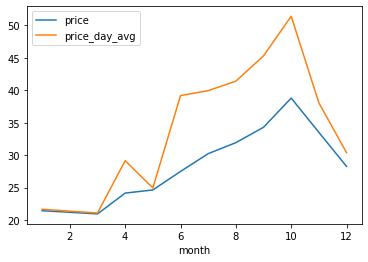

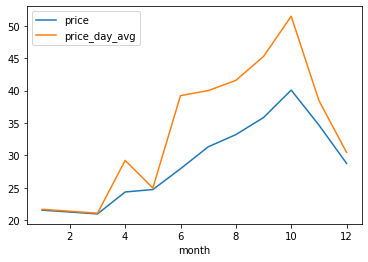

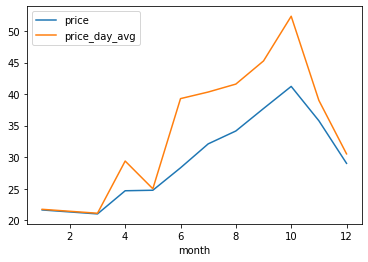

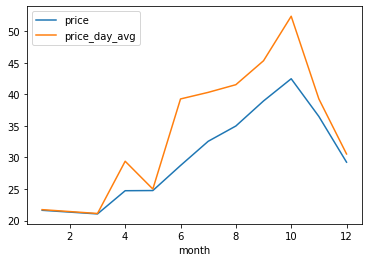

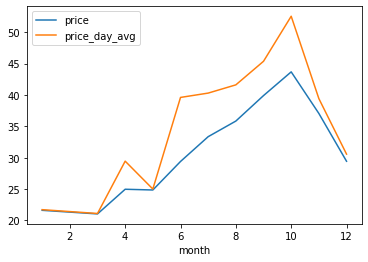

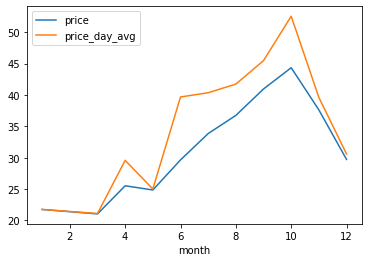

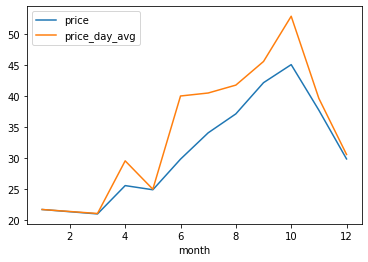

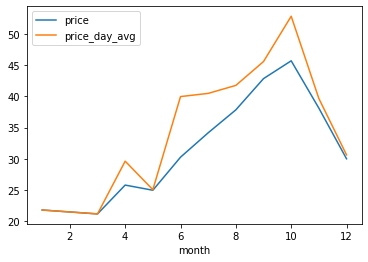

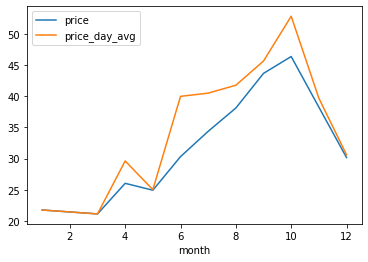

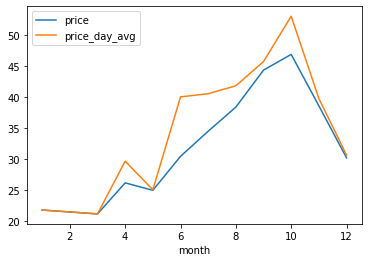

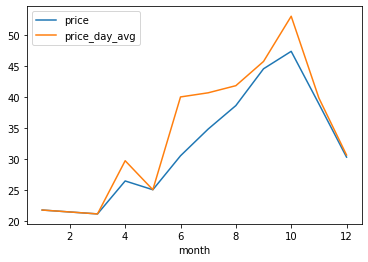

In [45]:
avg_threshold = 30
def curtail_function(row, curtail):
    if row['price_day_avg'] <= avg_threshold or row['price'] <= curtail:
        return 'N'
    return 'Y'
for curtail in range(50,105, 5):
    print("*"*100)
    print("Curtail at "+ str(curtail))
    df_dam['curtail'] = df_dam.apply( lambda row: curtail_function(row, curtail), axis = 1)
    df_curtail = df_dam [df_dam['curtail'] == 'N' ]
    print(df_curtail.groupby('month').mean())
    df_curtail.groupby('month').mean().plot(legend=True)
    print("Overall Average ", df_curtail['price'].mean())
    print("Uptime percentage ", df_curtail['Date'].count()/df_dam['Date'].count())
    curtail_analysis = curtail_analysis.append({'curtail' : curtail, 'average' :df_curtail['price'].mean(), 'uptime' : df_curtail['Date'].count()/df_dam['Date'].count()}, 
                ignore_index = True)
                                           

In [39]:
curtail_analysis

,curtail,average,uptime
0,50.0,27.971589,0.856621
1,55.0,28.802837,0.886833
2,60.0,29.531871,0.910247
3,65.0,30.093444,0.926234
4,70.0,30.687334,0.941213
5,75.0,31.186907,0.952669
6,80.0,31.530471,0.959844
7,85.0,31.867665,0.966264
8,90.0,32.146976,0.971173
9,95.0,32.350437,0.974446


<AxesSubplot:title={'center':'Average after curtail'}, xlabel='curtail'>

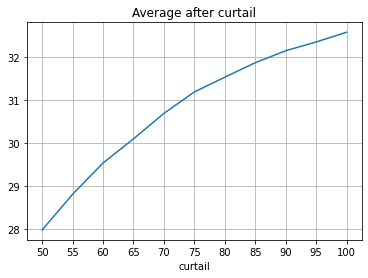

In [40]:
curtail_analysis.plot(x ='curtail', y='average', kind = 'line', title="Average after curtail", 
                      xticks=range(50,105,5),
                      grid=True, legend=False)


<AxesSubplot:title={'center':'Uptime after curtail'}, xlabel='curtail'>

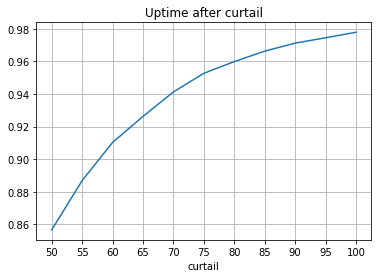

In [41]:
curtail_analysis.plot(x ='curtail', y='uptime', kind = 'line', title="Uptime after curtail", 
                      xticks=range(50,105,5),
                      #yticks=range(0.84,1.0,0.02),
                      grid=True, legend=False)
